In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares, fsolve
from tqdm import tqdm

plt.style.use('classic')
np.random.seed(0)

**Primal**

$$\begin{align*}
-\nabla \cdot (A^* \nabla u) &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla u)\vert_{\Gamma_2} &= 1\\
u\vert_{\Gamma_3}&=0
\end{align*}$$

**Dual**

$$\begin{align*}
\nabla \cdot (A^* \nabla p) &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_1} &= 0\\
\frac{d}{dn}(A^*\nabla p)\vert_{\Gamma_2} &= 0\\
p\vert_{\Gamma_3}&=\rho
\end{align*}$$

In [2]:
class finite_differences():
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = dx
        self.dy = dy
    def grad(self,v):
        v = v.reshape(self.m,self.n)
        return np.array(np.gradient(v,self.dx,self.dy,axis=(1,0),edge_order=2))
    def div(self,v):
        v = v.reshape(2,self.m,self.n)
        return np.array(np.gradient(v[0],self.dx,axis=(1),edge_order=2))+np.array(np.gradient(v[1],self.dy,axis=(0),edge_order=2))
    def divGrad(self,v):
        v = v.reshape(self.m,self.n)
        return self.div(self.grad(v))
    def Agrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return mult(self.A,self.grad(v))
    def divAgrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return self.div(mult(self.A,self.grad(v)))

**Design Matrix**
$$\begin{align*}
\lambda_- &= \bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-1}\\[2ex]
\lambda_+ &= \alpha\theta+\beta(1-\theta)
\end{align*}$$

In [3]:
def genLam(theta,shape,alpha=1,beta=.5):
    lamMinus=np.ma.power(theta/alpha+(np.ones(shape)-theta)/beta,-1)
    lamPlus=alpha*theta+beta*(np.ones(shape)-theta)
    return lamMinus,lamPlus

$$\begin{align*}
A^* &= \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}
\begin{pmatrix} \lambda_+ & 0\\ 0 & \lambda_-\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\[2ex]
&=\begin{pmatrix}
\lambda_+\cos^2(\phi)+\lambda_-\sin^2(\phi) & (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi)
\\ (-\lambda_++\lambda_-)\sin(\phi)\cos(\phi) & \lambda_+\sin^2(\phi)+\lambda_-\cos^2(\phi)
\end{pmatrix}\end{align*}$$

In [4]:
def genA(theta,phi,shape,alpha=1,beta=.1):
    A = np.zeros(shape+[2,2])
    lamPlus,lamMinus=genLam(theta,shape,alpha,beta)
    #BLOCK A
    for i in range(shape[0]):
        for j in range(shape[1]):
            A1=lamPlus[i,j]*np.cos(phi[i,j])**2+lamMinus[i,j]*np.sin(phi[i,j])**2
            A2=(lamPlus[i,j]+lamMinus[i,j])*np.sin(phi[i,j])*np.cos(phi[i,j])
            A3=lamPlus[i,j]*np.sin(phi[i,j])**2+lamMinus[i,j]*np.cos(phi[i,j])**2
            A[i,j]=np.array([[A1,A2],[A2,A3]])
    return A

$$\begin{align*}
\frac{\partial\lambda_-}{\partial\theta} &= -\bigg(\frac{1}{\alpha} - \frac{1}{\beta}\bigg)\bigg(\frac{\theta}{\alpha} + \frac{1-\theta}{\beta}\bigg)^{-2}\\
\frac{\partial\lambda_+}{\partial\theta} &= \alpha-\beta\\
\end{align*}$$

In [5]:
def lam_theta(theta,shape,alpha=1,beta=.5):
    n,m=shape
    lamMinus_theta =-np.ma.power((1/alpha-1/beta)*(theta/alpha+(np.ones(n,m)-theta)/beta),-2)
    lamPlus_theta=alpha*theta+beta*(np.ones(n,m)-theta)
    return lamPlus_theta,lamMinus_theta

$$\begin{align*}
\frac{\partial A}{\partial\theta} &= \begin{pmatrix} \cos(\phi) & \sin(\phi)\\ -\sin(\phi) & \cos(\phi)\end{pmatrix}
\begin{pmatrix} \frac{\partial\lambda_+}{\partial\theta} & 0\\ 0 & \frac{\partial\lambda_-}{\partial\theta}\end{pmatrix}
\begin{pmatrix} \cos(\phi) & -\sin(\phi)\\ \sin(\phi) & \cos(\phi)\end{pmatrix}\\
\end{align*}$$

In [6]:
def A_theta(thetaK,phiK,alpha=1,beta=.1):
    lamMinus_theta=-(1/alpha-1/beta)*((thetaK/alpha+(1-thetaK)/beta)**(-2))
    lamPlus_theta=alpha-beta

    A1=lamPlus_theta*np.cos(phiK)**2+lamMinus_theta*np.sin(phiK)**2
    A2=(-lamPlus_theta+lamMinus_theta)*np.sin(phiK)*np.cos(phiK)
    A3=lamPlus_theta*np.sin(phiK)**2+lamMinus_theta*np.cos(phiK)**2
  
    A_theta=np.array([[A1,A2],[A2,A3]])
    return A_theta

$$\begin{align*}
\frac{\partial A}{\partial\phi} &= \begin{pmatrix} (-\lambda_++\lambda_-)(2\cos(\phi)\sin(\phi)) & (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi))
\\ (-\lambda_++\lambda_-)(\cos^2(\phi)-\sin^2(\phi)) & (\lambda_+-\lambda_-)(2\cos(\phi)\sin(\phi)) \end{pmatrix}\end{align*}$$

In [7]:
def A_phi(thetaK,phiK,alpha=1,beta=.1):
    lamPlus=np.ma.power(thetaK/alpha+(1-thetaK)/beta,-1)
    lamMinus=alpha*thetaK-beta*(1-thetaK)

    A1=(-lamPlus+lamMinus)*2*np.sin(phiK)*np.cos(phiK)
    A2=(-lamPlus+lamMinus)*(np.cos(phiK)**2-np.sin(phiK)**2)
    A3=(lamPlus-lamMinus)*2*np.sin(phiK)*np.cos(phiK)

    A_phi=np.array([[A1,A2],[A2,A3]])
    return A_phi

**Design Method**

* Solve $\nabla u$

$$\begin{align*}
-\nabla \cdot (A^* \nabla u) &= \sigma - \rho\\
\frac{\partial u}{\partial n} = 0,&\quad \text{ on } \partial \Omega \end{align*}$$

* Solve $\nabla p$
$$\begin{align*}
-\nabla \cdot (A^* \nabla p) &= -2(u-u_0)\\
p = 0,&\quad \text{ on } \partial \Omega \end{align*}$$

* Update $\theta$
$$\begin{align*}
\theta_{k+1} = \max \bigg( 0,\min \bigg(1,\theta_k-t_k\bigg(\ell_k+\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\bigg) \bigg)\bigg)\end{align*}$$

* Update $\phi$
$$\begin{align*}
\phi_{k+1} = \phi_k-t_k\frac{\partial A^*}{\partial \theta}(\theta_k,\phi_k)\nabla u_k\cdot \nabla p_k\end{align*}$$

In [8]:
class heatLens():
    def __init__(self,x,y,options={}):
        #DOMAIN
        self.m=len(x)
        self.n=len(y)
        self.dx = 1/(m+1)
        self.dy = 1/(n+1)
        self.domain_len = self.m*self.n
        self.domain_shape = (self.m,self.n)
        self.xx, self.yy = np.meshgrid(x,y)
        self.zeros = np.zeros(self.domain_shape)
        self.ones = np.ones(self.domain_shape)
        self.interior = np.ones(self.domain_shape);
        self.interior[0,:]=np.zeros(m);self.interior[-1,:]=np.zeros(m);
        self.interior[:,0]=np.zeros(n);self.interior[:,-1]=np.zeros(n)
        #OPTIONS
        self.options=options
        self.check_options()
        #BOUNDARY DATA
        self.neumann_bcs = self.options['neumann_bcs']
        self.dirichlet_bcs = self.options['dirichlet_bcs']
        self.neumann_loc = self.options['neumann_loc']
        self.dirichlet_loc = self.options['dirichlet_loc']
        #INITIALIZE
        self.u=np.random.rand(self.domain_len).reshape(self.domain_shape)
        self.p=np.random.rand(self.domain_len).reshape(self.domain_shape)
        self.theta=np.zeros(self.domain_shape)#np.random.rand(self.domain_len).reshape(self.domain_shape)
        self.phi=np.zeros(self.domain_shape)#np.pi*np.random.rand(self.domain_len).reshape(self.domain_shape)#
        self.lv=self.options['lv']
        self.vol=self.options['volume']
        #DIFFERENCES
        self.fd = finite_differences(m,n,dx,dy)
        self.contract = lambda a,b,c : np.einsum('ijk,ijk->jk',b,
                        np.einsum('ijkl,jkl->ikl',a,c))

    def iterate(self,k):
        pbar = tqdm(range(k))
        for _ in pbar:
            self._iter()
            pbar.set_description(desc=str(self.lv))

    def _iter(self):
        #INITIALIZE
        alpha=self.options['alpha']
        beta=self.options['beta']
        tk=self.options['tk']
        #COEFFICIENTS
        A=genA(self.theta,self.phi,[self.m,self.n],alpha=alpha,beta=beta)
        self.fd.A = A.T
        #PRIMAL SOLUTION VIA RESIDUAL
        primal = lambda v : (self.interior*(-self.fd.divAgrad(v))
                                +self.dirichlet_loc*(v.reshape(domain_shape)) #T=0
                                +self.neumann_loc[0]*(self.fd.Agrad(v)[0]-self.neumann_bcs[0])
                                +self.neumann_loc[1]*(self.fd.Agrad(v)[1]-self.neumann_bcs[1])
                                ).reshape(self.domain_len)
        u = fsolve(primal,self.u,xtol=self.dx**2)
        Du = self.fd.grad(u)       
        #ADJOINT SOLUTION VIA RESIDUAL
        adjoint = lambda v : (self.interior*(self.fd.divAgrad(v))
                                +self.dirichlet_loc*(v.reshape(domain_shape)-self.dirichlet_bcs)
                                +self.neumann_loc[0]*self.fd.Agrad(v)[0]#D/DN(ADp) = D/DX BCs
                                +self.neumann_loc[1]*self.fd.Agrad(v)[1]#D/DN(ADp) = D/DX BCs
                                ).reshape(self.domain_len)
        p = fsolve(adjoint,self.p,xtol=self.dx**2)
        Dp = self.fd.grad(p)
        for i in range(self.m):
            for j in range(self.n):
                A_t=A_theta(self.theta[i,j],self.phi[i,j],alpha=alpha,beta=beta)
                rhs=self.theta[i,j]-tk*(self.lv+A_t@Du[:,i,j]@Dp[:,i,j])
                self.theta[i,j]=max([0,min([1,rhs])])
        for i in range(self.m):
            for j in range(self.n):
                A_p=A_phi(self.theta[i,j],self.phi[i,j],alpha=alpha,beta=beta)
                self.phi[i,j]=self.phi[i,j]-tk*(A_p@Du[:,i,j]@Dp[:,i,j])
#                 self.phi[i,j]=np.mod(self.phi[i,j]-tk*(A_p@Du[:,i,j]@Dp[:,i,j]),2*np.pi)
        
        self.lv = max(0,(np.sum(self.theta)*(self.dx*self.dy)-self.vol)/tk)
        #SOLUTION DATA
        self.u = u
        self.p = p
        self.Du = Du
        self.Dp = Dp
        self.ADu=self.fd.Agrad(u)
        self.ADp=self.fd.Agrad(p)
        self.sol=self.fd.divAgrad(u)

    def check_options(self):
        assert ('neumann_loc' in self.options) and ('dirichlet_loc' in self.options), 'No boundary conditions provided.'
        assert ('neumann_bcs' in self.options) or ('dirichlet_bcs' in self.options), 'No boundary conditions provided.'
        if not('alpha' in self.options):
            self.options['alpha']=.1
        if not('beta' in self.options):
            self.options['beta']=1
        if not('tk' in self.options):
            self.options['tk']=.1
        if not('lv' in self.options):
            self.options['lv']=0
        if not('volume' in self.options):
            self.options['volume']=.5

## Example 1

In [9]:
#GRID
L = 2
n,m=40,40
y=np.linspace(-L/2,L/2,n)
x=np.linspace(-L/2,L/2,m)
dx = L/(n+1)
dy = L/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)

In [10]:
neumann_bcs = np.zeros([2]+list(domain_shape))
neumann_bcs[1,-1,:] = np.ones(m)
neumann_loc = np.zeros([2]+list(domain_shape))
neumann_loc[0,:,-1] = np.ones(n)
neumann_loc[0,:,0] = np.ones(n)
neumann_loc[1,-1,:] = np.ones(n)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc[0,:] = np.ones(n)
dirichlet_bcs = np.zeros(domain_shape); dirichlet_bcs[0,3*n//8:5*n//8]=np.ones(n//4)
options={'lv':0, 'volume':.75,
         'neumann_bcs':neumann_bcs,'neumann_loc':neumann_loc,
         'dirichlet_loc':dirichlet_loc,'dirichlet_bcs':dirichlet_bcs}
prob = heatLens(x,y,options)

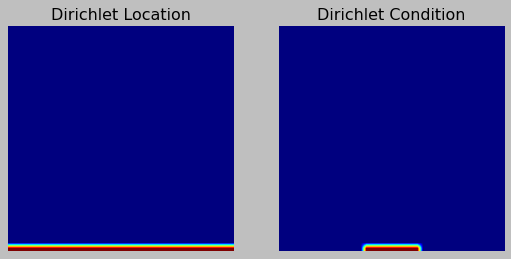

In [11]:
plt.subplot(121)
plt.title('Dirichlet Location')
plt.imshow(prob.dirichlet_loc[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Dirichlet Condition')
plt.imshow(prob.dirichlet_bcs[::-1])
plt.axis('off')
plt.show()

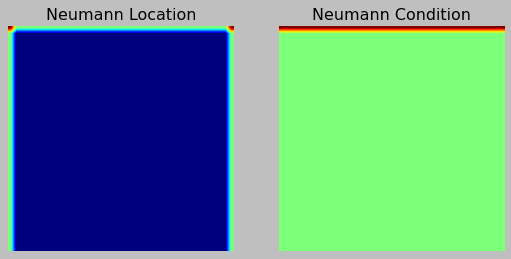

In [12]:
plt.subplot(121)
plt.title('Neumann Location')
plt.imshow((prob.neumann_loc[0]+prob.neumann_loc[1])[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Neumann Condition')
plt.imshow((prob.neumann_bcs[0]+prob.neumann_bcs[1][::-1]),vmax=1,vmin=-1)
plt.axis('off')
plt.show()

In [13]:
prob.iterate(10)

0: 100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [01:52<00:00, 11.21s/it]


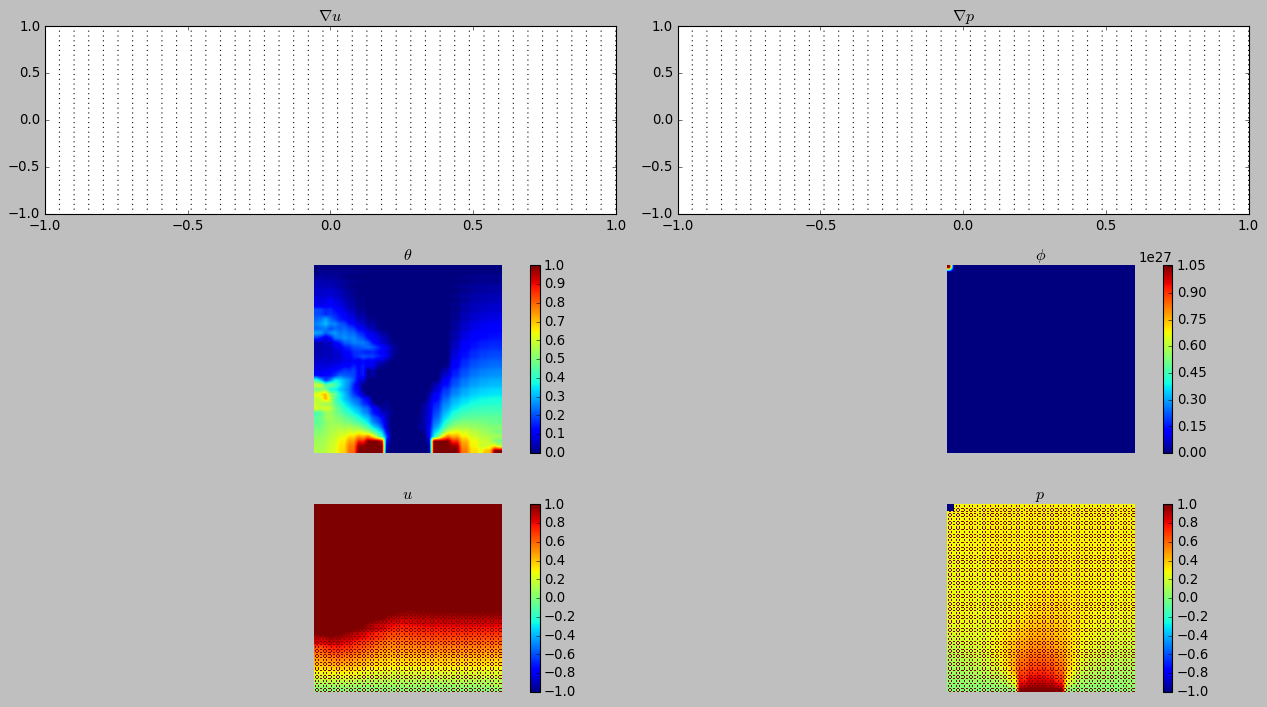

In [14]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(321)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.Du[0][1:-1],prob.Du[1][1:-1])
plt.title('$\\nabla u$')
plt.subplot(322)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.Dp[0][1:-1],prob.Dp[1][1:-1])
plt.title('$\\nabla p$')
plt.subplot(323)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\theta$')
plt.axis('off')
plt.subplot(324)
plt.imshow(prob.phi.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\phi$')
plt.axis('off')
plt.subplot(325)
plt.imshow(prob.u.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$u$')
plt.axis('off')
plt.subplot(326)
plt.imshow(prob.p.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$p$')
plt.axis('off')
plt.show()

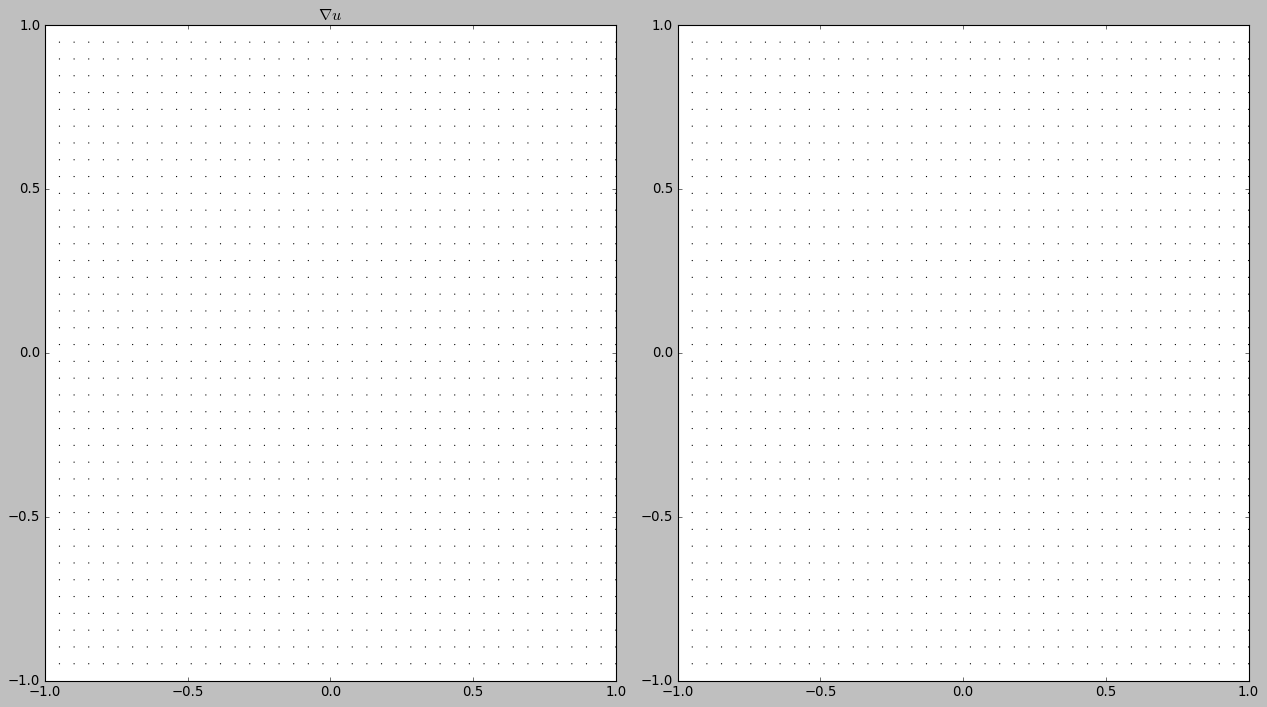

In [15]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(121)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.ADu[0][1:-1],prob.ADu[1][1:-1])
plt.title('$\\nabla u$')
plt.subplot(122)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.ADp[0][1:-1],prob.ADp[1][1:-1])
plt.show()

In [16]:
print(prob.ADu[0][:,-1])
print(prob.ADu[0][:,0])
print(prob.ADu[1][-1,:])
print(prob.ADp[1][-1,:])

[ 2.56595902e-23  8.88178420e-17 -2.08166817e-16 -8.18789481e-16
  5.13478149e-16  7.07767178e-16  2.47024623e-15  9.71445147e-17
  1.70696790e-15 -8.46545056e-16 -1.45716772e-15 -2.04697370e-15
 -1.73125403e-15  4.19456136e-15 -3.74244906e-15  8.25240484e-15
  3.81639165e-15  2.81545620e-15 -1.49186219e-15 -6.91113833e-15
 -5.00988140e-15  1.83880688e-15  1.24206201e-15  7.09154957e-15
  1.00752739e-14 -1.86656246e-15  9.14546217e-15 -5.19029264e-15
 -8.12544476e-15 -5.40539835e-15 -1.71598846e-14 -4.90579799e-15
 -9.22872889e-16  9.59649027e-15 -1.39471767e-15 -1.20459198e-14
 -3.29944405e-15  4.53630189e-15 -7.42244807e-16  2.08465981e-03]
[-5.66844310e-25 -1.88406599e-17 -1.49066080e-16  2.12427726e-16
 -2.09919042e-16 -3.85499246e-16 -1.27533139e-16 -3.33413850e-16
 -7.74610656e-16 -1.02239753e-24  1.40553088e-24 -1.77635684e-16
 -3.55271368e-16 -1.77635684e-16 -5.32907052e-16 -5.02375919e-15
  1.72008206e-19  3.55270356e-15  3.55271640e-15 -5.32907213e-15
  3.17055836e-22 -5.3290

## Example 2

In [17]:
#GRID
L = 2
n,m=40,40
y=np.linspace(-L/2,L/2,n)
x=np.linspace(-L/2,L/2,m)
dx = L/(n+1)
dy = L/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)

In [18]:
neumann_bcs = np.zeros([2]+list(domain_shape))
neumann_bcs[1,-m//8:,0] = np.ones(m//8)
neumann_bcs[1,-m//8:,-1] = np.ones(m//8)
neumann_loc = np.zeros([2]+list(domain_shape))
neumann_loc[0,:,-1] = np.ones(n)
neumann_loc[0,:,0] = np.ones(n)
neumann_loc[1,-1,:] = np.ones(n)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc[0,:] = np.ones(n)
dirichlet_bcs = np.zeros(domain_shape); dirichlet_bcs[0,3*n//8:5*n//8]=np.ones(n//4)
options={'lv':1, 'volume':.75,
         'neumann_bcs':neumann_bcs,'neumann_loc':neumann_loc,
         'dirichlet_loc':dirichlet_loc,'dirichlet_bcs':dirichlet_bcs}
prob = heatLens(x,y,options)

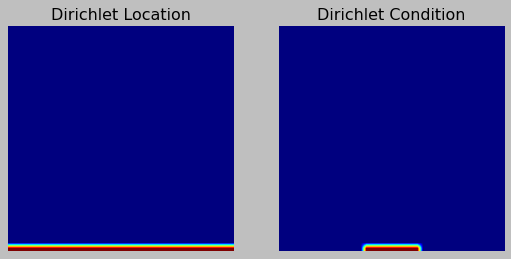

In [19]:
plt.subplot(121)
plt.title('Dirichlet Location')
plt.imshow(prob.dirichlet_loc[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Dirichlet Condition')
plt.imshow(prob.dirichlet_bcs[::-1])
plt.axis('off')
plt.show()

(-0.5, 39.5, 39.5, -0.5)

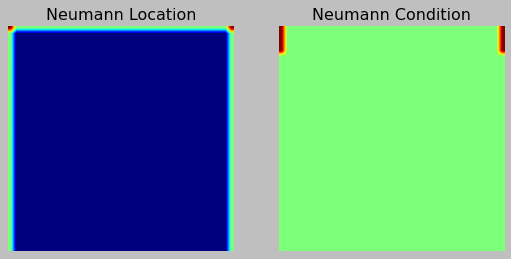

In [20]:
plt.subplot(121)
plt.title('Neumann Location')
plt.imshow((prob.neumann_loc[0]+prob.neumann_loc[1])[::-1])
plt.axis('off')
plt.subplot(122)
plt.title('Neumann Condition')
plt.imshow((prob.neumann_bcs[0]+prob.neumann_bcs[1][::-1]),vmax=1,vmin=-1)
plt.axis('off')

In [21]:
prob.iterate(10)

0: 100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [01:57<00:00, 11.78s/it]


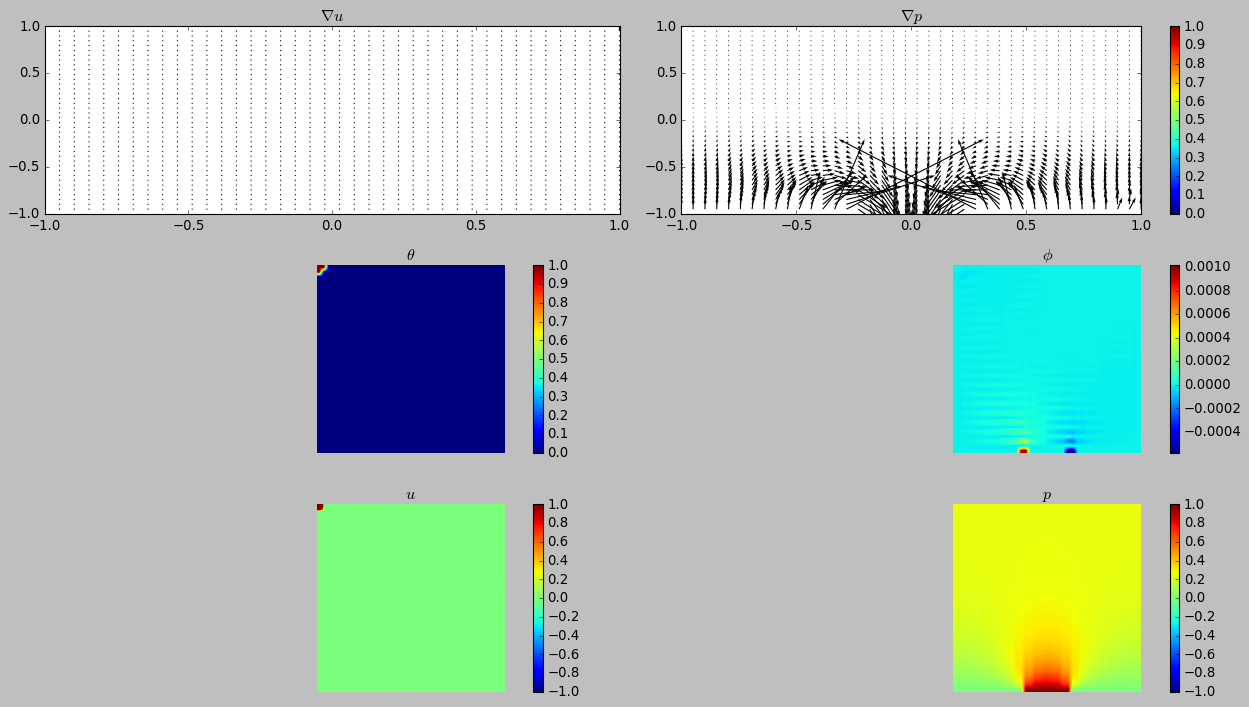

In [22]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(321)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.Du[0][1:-1],prob.Du[1][1:-1])
plt.title('$\\nabla u$')
plt.subplot(322)
plt.quiver(prob.xx[1:-1],prob.yy[1:-1],prob.Dp[0][1:-1],prob.Dp[1][1:-1])
plt.colorbar()
plt.title('$\\nabla p$')
plt.subplot(323)
plt.imshow(prob.theta.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\theta$')
plt.axis('off')
plt.subplot(324)
plt.imshow(prob.phi.reshape(prob.domain_shape)[::-1])
plt.colorbar()
plt.title('$\\phi$')
plt.axis('off')
plt.subplot(325)
plt.imshow(prob.u.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$u$')
plt.axis('off')
plt.subplot(326)
plt.imshow(prob.p.reshape(prob.domain_shape)[::-1],vmin=-1,vmax=1)
plt.colorbar()
plt.title('$p$')
plt.axis('off')
plt.show()